# ChemTab (PCDNN_V2) Benchmark Notebook
### This notebook contains experiments around the different parameters for the model
#### Amol Salunkhe

Develop a deep neural architecture ChemTab that jointly optimizes two neural networks for the tasks of reduced basis learning (encoder) and reverse lookup function learning (regressor). The first network (Shallow AutoEncoder) will focus on linear dimensionality reduction and create a linear embedding for the source species. The second network (Deep Regressor) will focus on learning a lookup function from the linear embedding to the Thermo-chemical state variables.

### Overall Problem Formulation

\begin{equation}\label{eqn:lossfunc}
    \begin{aligned}
    \textrm{min} \quad \mathcal{L}_{joint} = \lambda_{encoder} * \mathcal{L}_{encoder} + \lambda_{regressor}* \mathcal{L}_{regressor} 
    \end{aligned}
\end{equation}

### Reduced Basis Problem Formulation (Encoder)

\begin{equation}\label{eqn:Reduced-Basis-Learning}
    \begin{aligned}
    \def\sss{\scriptscriptstyle}
    {}
    \def\stacktype{L}
        {\mathrm{Y^{'}}}{\sss n\times k} =  {Y}{\sss n\times s} \times {W}{\sss s\times k} \\
        \textrm{s.t.,} \quad k \ll s\\
        \mathrm{\phi}(Y) \approx \mathrm{\phi}(Y^{'})\\
        \textrm{where, W is the Reduced Basis / encoder} \\
        \mathrm{\phi} \quad \textrm{is the Reverse Lookup function / regressor}
    \end{aligned}
\end{equation}


### Lookup Learning Problem Formulation (Regressor)

\begin{equation}\label{eqn:Reverse-Lookup-Learning}
    \begin{aligned}
        \textrm{min} \quad ||{S_i} - \mathrm{\phi}(Y^{'}_i)||_{p}\\
        \textrm{s.t.,} \quad p \in r \\
        \quad k \ll s\\
        \mathrm{\phi}(Y) \approx \mathrm{\phi}(Y^{'})\\
    \end{aligned}
\end{equation}




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
import time
from sklearn.decomposition import PCA, SparsePCA
%matplotlib inline
import seaborn as sns
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
import sys

## Helpers

In [2]:
from benchmark_model_code import * # Network Helpers
from benchmark_data_code import * # Data Helpers

### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; All Constraints)

## Debugging Code:

In [3]:
import random
import numpy as np
from copy import deepcopy
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
halfData = getHalfData()

# apply aliases to sync naming conventions
aliases = {'normalized_species_train': 'X_train',
           'normalized_species_test': 'X_test',
           'normalized_souener_train': 'Y_train',
           'normalized_souener_test': 'Y_test'}
control_dict = deepcopy(halfData)
for key in aliases:
    control_dict[aliases[key]]=control_dict[key]

control_keys = ['X_train', 'X_test', 'Y_train', 'Y_test', 'Zmix_train', 'Zmix_test']
control_dict = {k:v for k,v in control_dict.items() if k in control_keys}
print(control_dict.keys())

dict_keys(['X_train', 'X_test', 'Zmix_train', 'Zmix_test', 'Y_test', 'Y_train'])


/home/dwyerdei/rom_project2/src/benchmark_data_code.py:267: UserWarning: transparently scaling Zmix!
  warnings.warn('transparently scaling Zmix!')


In [4]:
locals().update(control_dict)
to_series = lambda x: map(pd.DataFrame, x)
train_df = pd.concat(to_series([X_train, Y_train, Zmix_train]), axis=1)
test_df = pd.concat(to_series([X_test, Y_test, Zmix_test]), axis=1)
show_shape = lambda x: print(f'{x} shape: {globals()[x].shape}')
for name in control_dict.keys():
    show_shape(name)

X_train shape: (8220, 53)
X_test shape: (8219, 53)
Zmix_train shape: (8220,)
Zmix_test shape: (8219,)
Y_test shape: (8219,)
Y_train shape: (8220,)


In [5]:
pd.Series(Zmix_train).describe()

count    8220.000000
mean        0.424267
std         0.261594
min         0.000000
25%         0.206433
50%         0.389754
75%         0.623716
max         1.000000
dtype: float64

In [6]:
train_df.head()

0         1             2         3             4         5   \
0  3.052720e-03  0.739546  1.620786e-01  0.058566  4.532765e-01  0.973600   
1  1.370376e-03  0.690356  6.058872e-02  0.008392  2.851919e-01  0.993701   
2  7.603245e-01  0.000002  1.801694e-10  0.000011  2.613677e-10  0.204827   
3  7.428536e-01  0.000009  1.017217e-08  0.000200  5.422674e-09  0.237570   
4  8.945454e-17  0.019809  9.795518e-02  0.917386  3.276519e-02  0.105000   

         6         7             8             9   ...            45  \
0  0.078707  0.113936  9.188343e-01  8.682632e-01  ...  5.304347e-22   
1  0.010930  0.024512  5.948479e-01  4.070613e-01  ...  2.562147e-19   
2  0.000003  0.000010  5.123643e-13  4.413584e-20  ...  2.664260e-05   
3  0.000051  0.000145  1.196362e-10  1.528550e-12  ...  4.111322e-18   
4  0.615187  0.609395  1.032810e-16  1.036462e-16  ...  2.364785e-25   

             46            47            48            49            50  \
0  2.727593e-21  5.528960e-03  2.097720e-05  9.425339e-02  4.707824e-02   
1  7.826801e-19  5.333809e-04  3.110139e-06  4.374912e-03  3.521961e-03   
2  1.209949e-10  1.480544e-03  1.049768e-02  9.610820e-04  1.586097e-04   
3  3.801845e-20  4.842577e-03  5.265232e-02  2.940767e-03  7.541735e-04   
4  7.765171e-25  9.850460e-22  6.877619e-23  3.423556e-14  4.328387e-16   

             51        52        0         0   
0  4.509180e-26  0.272059  0.493713  0.265079  
1  3.773930e-28  0.246324  0.097607  0.294420  
2  3.257910e-06  0.301471  0.013810  0.849163  
3  2.145198e-24  0.095588  0.013848  0.835522  
4  6.308446e-23  0.040441  0.076645  0.015615  

[5 rows x 55 columns]

In [7]:
test_df.head()

0         1         2         3         4         5         6   \
0  0.217373  0.022310  0.000339  0.042504  0.002821  0.784546  0.045262   
1  0.160431  0.044194  0.000848  0.046350  0.007785  0.842270  0.058368   
2  0.865642  0.000022  0.000002  0.007983  0.000002  0.134784  0.003959   
3  0.011240  0.517360  0.075199  0.068045  0.287013  0.981558  0.117047   
4  0.491435  0.001106  0.000008  0.020110  0.000028  0.510264  0.011298   

         7             8             9   ...            45            46  \
0  0.082376  1.108135e-03  2.596495e-03  ...  1.246048e-17  2.677223e-18   
1  0.121180  5.823460e-03  1.302966e-02  ...  1.312652e-17  4.500783e-18   
2  0.012738  3.932975e-10  4.862828e-10  ...  2.478598e-18  2.212659e-19   
3  0.210518  7.246139e-01  9.742399e-01  ...  3.486579e-19  1.099624e-18   
4  0.026445  9.560773e-07  1.390714e-06  ...  5.107903e-19  1.218446e-20   

         47        48        49        50            51        52        0   \
0  0.410519  0.327413  0.074502  0.248883  3.636513e-23  0.097902  0.040648   
1  0.647866  0.175942  0.113691  0.273004  3.856739e-23  0.276224  0.033097   
2  0.015496  0.299883  0.057551  0.046214  6.470884e-24  0.076923  0.016464   
3  0.066848  0.000420  0.283508  0.168837  2.729184e-23  0.391608  0.507472   
4  0.022487  0.722173  0.041160  0.111172  1.691223e-23  0.108392  0.029151   

         0   
0  0.468743  
1  0.428316  
2  0.908983  
3  0.282793  
4  0.658965  

[5 rows x 55 columns]

In [8]:
"""
df.describe()
df['souener'].describe()
sns.pairplot(df[df.columns[:-5]])
"""

"\ndf.describe()\ndf['souener'].describe()\nsns.pairplot(df[df.columns[:-5]])\n"

## Debugging Code End

In [9]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="linear",kernel_constraint=UnitNorm(axis=0),kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0),activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.))(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 species_input (InputLayer)     [(None, 53)]         0           []                               
                                                                                                  
 Zmix (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 4)            216         ['species_input[0][0]']          
                                                                                                  
 concatenate (Concatenate)      (None, 5)            0           ['Zmix[0][0]',                   
                                                                  'dense[0][0]']              

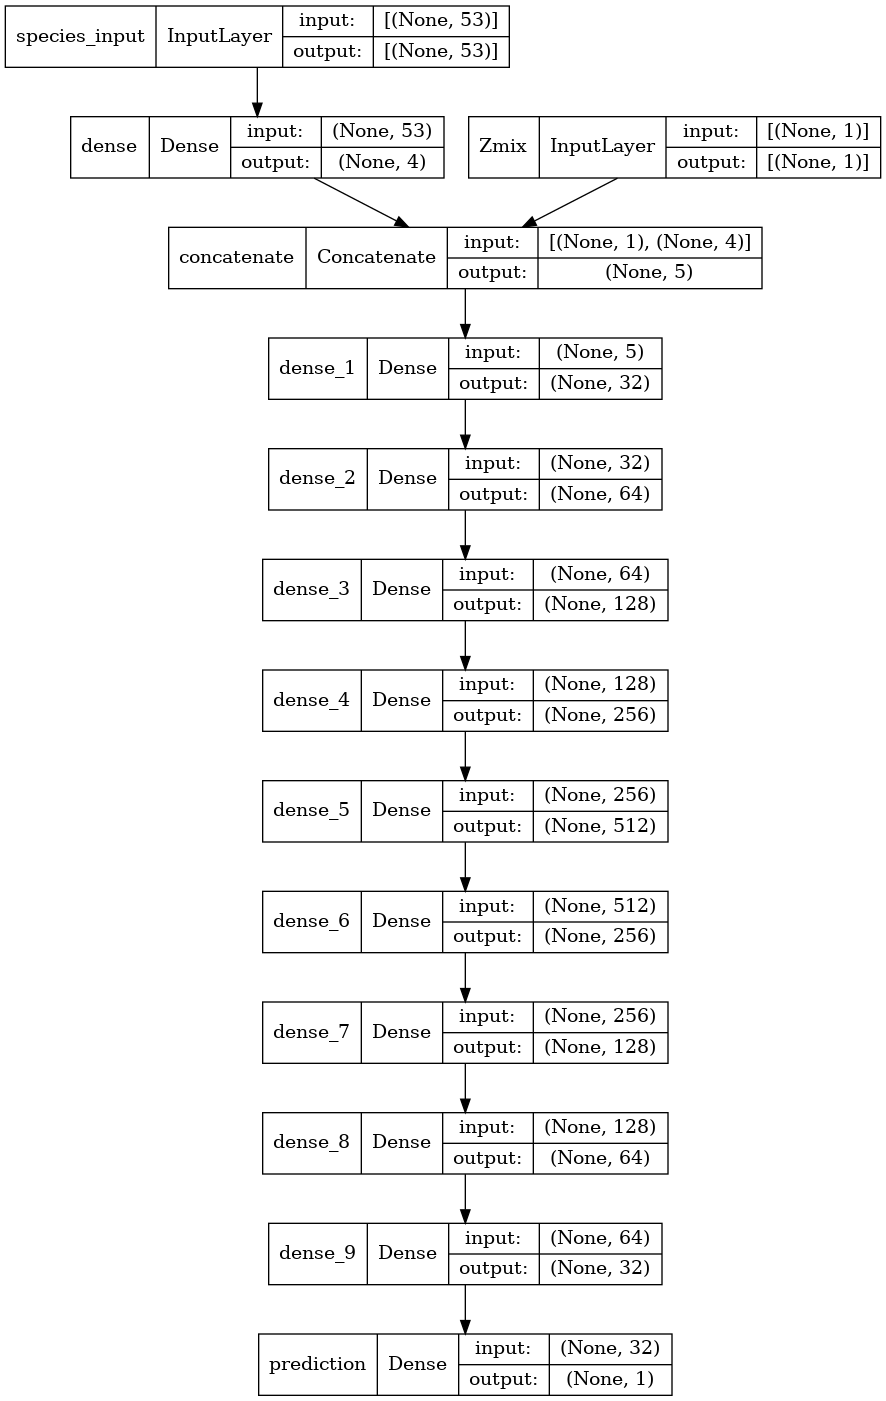

In [10]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [11]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [12]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                     normalized_souener_train,
                     validation_split=0.2,
                     verbose=1, 
                     epochs=100,
                     batch_size=32,
                     callbacks=[es])

Epoch 1/100
206/206 [==============================] - 3s 9ms/step - loss: 0.0760 - val_loss: 0.0139
Epoch 2/100
206/206 [==============================] - 2s 8ms/step - loss: 0.0172 - val_loss: 0.0158
Epoch 3/100
206/206 [==============================] - 2s 8ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 4/100
206/206 [==============================] - 2s 8ms/step - loss: 0.0125 - val_loss: 0.0101
Epoch 5/100
206/206 [==============================] - 2s 8ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 6/100
206/206 [==============================] - 2s 8ms/step - loss: 0.0130 - val_loss: 0.0100
Epoch 7/100
206/206 [==============================] - 2s 8ms/step - loss: 0.0126 - val_loss: 0.0148
Epoch 8/100
206/206 [==============================] - 2s 7ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 9/100
206/206 [==============================] - 1s 7ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 10/100
206/206 [==============================] - 1s 6ms/step - loss: 0.0088 - val_lo

206/206 [==============================] - 2s 9ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 82/100
206/206 [==============================] - 2s 9ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 83/100
206/206 [==============================] - 2s 9ms/step - loss: 0.0049 - val_loss: 0.0067
Epoch 84/100
206/206 [==============================] - 2s 9ms/step - loss: 0.0073 - val_loss: 0.0100
Epoch 85/100
206/206 [==============================] - 2s 9ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 86/100
206/206 [==============================] - 2s 9ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 87/100
206/206 [==============================] - 2s 9ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 88/100
206/206 [==============================] - 2s 9ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 89/100
206/206 [==============================] - 2s 9ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 90/100
206/206 [==============================] - 2s 9ms/step - loss: 0.0045 - val_loss: 

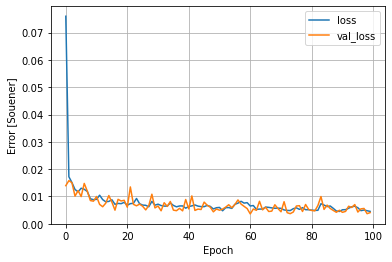

In [13]:
plot_loss(history)

In [14]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions

In [15]:
scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)
Y_pred = Y_pred.flatten()
Y_test = halfData["Y_test"]

In [16]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  4360174157902.7075
Mean Absolute Error:  530499350.03074676
Mean Percentage Error:  0.8658977906524155
Total Squared Error:  4.593771139855102e+22
Mean Squared Error:  5.589209319692301e+18
Number of Points:  8219


In [17]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

NameError: name 'getResiduals' is not defined

## RESULTS SUMMARY

<table>
<tr>
<td>Method </td>
<td>MAE</td>
</tr>
<tr>
<td>Framework </td>
<td>2.24 E+09</td>
</tr>
<tr>
<td>DNN (Non-Linear Embedding) </td>
<td>9.304 E+08</td>
</tr>    
<tr>
<td>DNN (Linear Embedding [No Constraints]) </td>
<td>2.042 E+09</td>
</tr>       
<tr>
<td>ChemTab (Unit Norm Constraints) </td>
<td>6.28 E+08</td>
</tr>
<tr>
<td>ChemTab (Orthogonal Weights Constraints) </td>
<td>6.05 E+08</td>
</tr>
<tr>
<td>ChemTab (Uncorrelated Features Constraints) </td>
<td>5.7 E+08</td>
</tr>
<tr>
<td>ChemTab (All Constraints) </td>
<td>8.008 E+08</td>
</tr>
    
</table>